In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model

In [2]:
df = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31") #"GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"

[*********************100%%**********************]  6 of 6 completed


In [3]:
df.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2010-01-04  6.487533  22.398512  17.768671  31.223448  15.610239  38.295723   
2010-01-05  6.498750  22.058916  17.912821  31.727247  15.541497  38.051384   
2010-01-06  6.395380  22.198751  18.190018  31.395475  15.149715  37.979191   
2010-01-07  6.383557  22.051424  18.350794  31.536787  14.797037  37.818146   
2010-01-08  6.425996  21.984003  18.104086  32.685696  14.994298  37.762608   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   
2010-01-08  7.570714  44.020000  32.654999  41.323200  ...  33.334999   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   
2010-01-08  40.740635  14.744733  68.133118  447610800.0  3307737.0   

                                                           
               BMW.DE      DBK.DE         GOOG     RWE.DE  
Date                                                       
2010-01-04  1808170.0   4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0   5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0   5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0   4506202.0  257533695.0  1765257.0  
2010-01-08  1925894.0  10753806.0  189680313.0  1665122.0  

[5 rows x 36 columns]

In [4]:
df = df["Adj Close"]

In [5]:
def logtransform(df):
    df = pd.DataFrame(np.diff(np.log(df[1:]), axis=0), columns=df.columns)
    return df

In [6]:
df = logtransform(df)

In [7]:
df = 100 * df

In [8]:
df = df.dropna(axis=0)

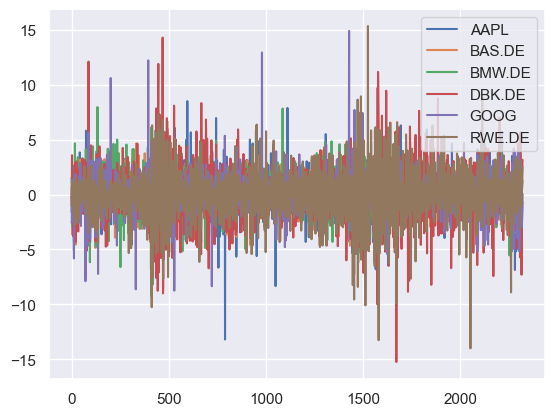

In [9]:
df.plot();

In [10]:
PF = df.mean(axis=1)

In [11]:
df

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,-1.603410,0.631917,1.535626,-1.051206,-2.553194,-0.189906
1,-0.185027,-0.665886,0.879987,0.449092,-2.355478,-0.424937
2,0.662610,-0.306213,-1.353518,3.578283,1.324303,-0.146964
3,-0.886063,-1.119373,-1.496376,-1.210279,-0.151272,1.169607
4,-1.144023,-3.625683,-2.949494,-2.621568,-1.784221,-1.022644
...,...,...,...,...,...,...
2312,1.290925,0.370667,-0.718780,-0.209092,1.191075,-1.091224
2313,-3.168862,1.469155,-0.027234,-1.502605,-0.555632,0.936049
2314,-2.555876,-0.982600,-2.216352,-7.298487,-1.338327,-0.857690
2315,-3.967239,1.610399,0.125201,0.598201,-3.003820,-0.313745


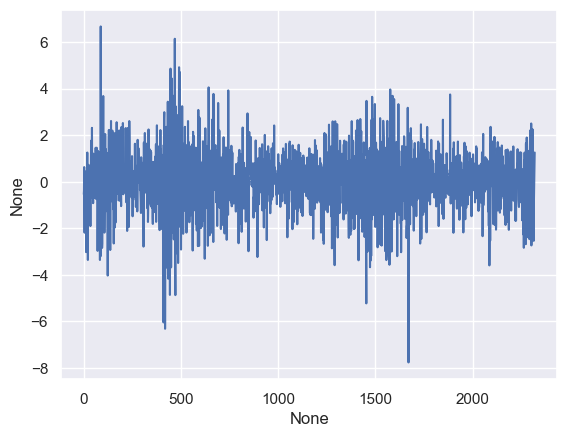

In [12]:
sns.lineplot(x = PF.index, y = PF);

GARCH

Estimate GARCH models for each return series $j=1,...,K$ and $t=1,..,T$

$r_{t,j} = \mu_{j}  + \epsilon_{t,j}$

$\epsilon_{t,j} = \sigma_{t,j} Z_{t,j} $


${\sigma_{t,j}}^2 = \omega_j +  \alpha_{k,j} r_{t-1,j}^2 + \beta_{k,j} \sigma_{t-1,j}^2$ 

$Z_{t,j}$ as assumed innovation distribution and standardized residuals as 

$\hat{z}_{t,j} = \frac{1}{\hat{\sigma}_{t,j}} \Bigl(  r_{t,j} - \hat{\mu}_j       \Bigr)$


In [13]:
def fit_copula(copula_data):
    copula = pv.Vinecop(copula_data.to_numpy())
    return copula

In [14]:
def fit_garch(data):
    am = arch_model(data, vol="Garch", p=1, o=0, q=1, dist="skewt", mean="constant")
    am_fitted = am.fit()

    return am, am_fitted


In [15]:
def transform_simulated_copula_data(data, am, am_fitted):
    return am.distribution.ppf(pits=data,parameters=am_fitted.params[-2:])

In [57]:
def sigma2_forecast(data, am_fitted):
    omega_t = am_fitted.params["omega"]
    alpha_t = am_fitted.params["alpha[1]"]
    beta_t = am_fitted.params["beta[1]"]
    sigma_t1 = omega_t + alpha_t * (data.iloc[-1])**2 + beta_t * am_fitted._volatility[-1]
    return sigma_t1**2

In [99]:
# return series forecasts
def get_series_forecast(sigma2_pred, am_fitted, transformed_data):
    mu = am_fitted.params["mu"]
    res = mu + sigma2_pred*transformed_data
    res = res.sort_values(ascending=True, ignore_index=True)

    return res

In [145]:
def make_forecast(df):
    std_resid_df = pd.DataFrame()
    copula_data_df = pd.DataFrame()
    garch_models = []
    for i in range(0, df.shape[1]):
        am, am_fitted = fit_garch(df.iloc[:,i])
        garch_models.append([am, am_fitted])
        std_resid = am_fitted.resid / am_fitted.conditional_volatility
        std_resid_df[i] = std_resid
        copula_data = am.distribution.cdf(std_resid, parameters=am_fitted.params[-2:])
        copula_data_df[i] = copula_data
    copula = fit_copula(copula_data_df)
    simulated_copula_data = pd.DataFrame(copula.simulate(1000))
    transformed_data = pd.DataFrame()
    for i in range(0, simulated_copula_data.shape[1]):
        am = garch_models[i][0]
        am_fitted = garch_models[i][1]
        transformed_data[i] = transform_simulated_copula_data(data=simulated_copula_data.iloc[:,i], am = am, am_fitted=am_fitted)
        
    sigma2_forecasts = pd.Series()
    for i in range(0, df.shape[1]):
        sigma2 = sigma2_forecast(data=df.iloc[:,i], am_fitted=garch_models[i][1])
        print(sigma2)
        sigma2_forecasts[i] = sigma2

    series_forecasts = pd.DataFrame()
    for i in range(0, df.shape[1]):
        series_forecasts[i] = get_series_forecast(sigma2_pred=sigma2_forecasts[i], am_fitted=garch_models[i][1], transformed_data=transformed_data[i])


    return series_forecasts.iloc[int(series_forecasts.shape[0]*0.01),:].mean()

    

In [147]:
pf_forecasts = pd.Series()

In [148]:
for i in range(0,100):
    pf_forecasts[i] = make_forecast(df=df.iloc[0+i:499+i,:])

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2001.0119868203028
Iteration:      2,   Func. Count:     17,   Neg. LLF: 19876.921649612796
Iteration:      3,   Func. Count:     26,   Neg. LLF: 14116.100683613951
Iteration:      4,   Func. Count:     35,   Neg. LLF: 937.7711051891063
Iteration:      5,   Func. Count:     44,   Neg. LLF: 1537.18866080982
Iteration:      6,   Func. Count:     52,   Neg. LLF: 935.7715386341736
Iteration:      7,   Func. Count:     60,   Neg. LLF: 935.9084123984555
Iteration:      8,   Func. Count:     68,   Neg. LLF: 931.255574271401
Iteration:      9,   Func. Count:     75,   Neg. LLF: 931.2118557457377
Iteration:     10,   Func. Count:     82,   Neg. LLF: 931.206678552359
Iteration:     11,   Func. Count:     89,   Neg. LLF: 931.2063378603189
Iteration:     12,   Func. Count:     96,   Neg. LLF: 931.2063091411874
Iteration:     13,   Func. Count:    102,   Neg. LLF: 931.2063091412077
Optimization terminated successfully    (Exit mode 0)
          

In [149]:
pf_forecasts

0    -13.858531
1    -11.311063
2    -21.163683
3    -11.206337
4    -13.819003
        ...    
95    -9.763540
96   -13.855119
97   -10.585101
98   -11.171204
99   -13.120127
Length: 100, dtype: float64

In [159]:
pf_actual = pd.Series(PF[500:600]).reset_index(drop=True)

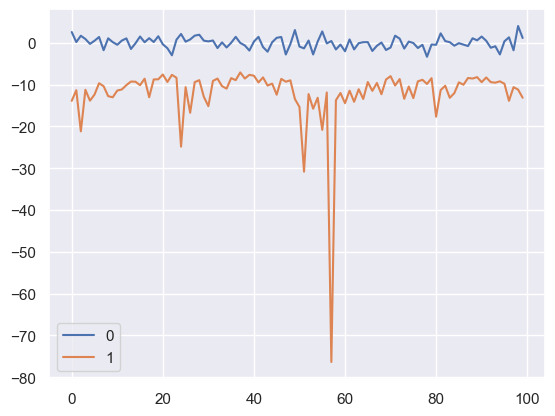

In [164]:
pd.DataFrame([pf_actual, pf_forecasts]).T.plot();